In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis"

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 12.8 MB/s 


In [ ]:
import time, os, random, json, PIL, shutil, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTO = tf.data.experimental.AUTOTUNE
print(tf.__version__)

Number of replicas: 1
2.8.0


## Model Parameters

In [ ]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 30
BATCH_SIZE = 1

# Prepare Dataset

## Load Data

In [ ]:
LC_train_FILENAMES = tf.io.gfile.glob(str('./Images/Tfrecord/LC25000_output/*.tfrec'))
TCGA_train_FILENAMES = tf.io.gfile.glob(str('./Images/Tfrecord/TCGA_output/*.tfrec'))
# TCGA_test_FILENAMES = tf.io.gfile.glob(str('./Images/LC25000/lung_image_sets_test_mix/TCGA2LC/TCGA_test_1/*.tfrec'))  # for test

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_LC_train_samples = count_data_items(LC_train_FILENAMES)
n_TCGA_train_samples = count_data_items(TCGA_train_FILENAMES)
n_TCGA_test_samples = count_data_items(TCGA_test_FILENAMES)

print(f'LC_train TFRecord files: {len(LC_train_FILENAMES)}')
print(f'LC_train image files: {n_LC_train_samples}')
print(f'TCGA_train TFRecord files: {len(TCGA_train_FILENAMES)}')
print(f'TCGA_train image files: {n_TCGA_train_samples}')
print(f'TCGA_test TFRecord files: {len(TCGA_test_FILENAMES)}')
print(f'TCGA_test image files: {n_TCGA_test_samples}')

LC_train TFRecord files: 5
LC_train image files: 450
TCGA_train TFRecord files: 5
TCGA_train image files: 248
TCGA_test TFRecord files: 0
TCGA_test image files: 0.0


## Auxiliar functions

In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.resize(image, [HEIGHT, WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'name': tf.io.FixedLenFeature([], tf.string),
        'image':      tf.io.FixedLenFeature([], tf.string),
        #'target':     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_gan_dataset(LC_files, TCGA_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    LC_ds = load_dataset(LC_files)
    TCGA_ds = load_dataset(TCGA_files)

    if repeat:
        LC_ds = LC_ds.repeat()
        TCGA_ds = TCGA_ds.repeat()
    if shuffle:
        LC_ds = LC_ds.shuffle(2048)
        TCGA_ds = TCGA_ds.shuffle(2048)
        
    LC_ds = LC_ds.batch(batch_size, drop_remainder=True)
    TCGA_ds = TCGA_ds.batch(batch_size, drop_remainder=True)
    LC_ds = LC_ds.cache()
    TCGA_ds = TCGA_ds.cache()
    LC_ds = LC_ds.prefetch(AUTO)
    TCGA_ds = TCGA_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((LC_ds, TCGA_ds))
    
    return gan_ds

def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(10, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()
        
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1
                

# Model functions
def downsample(filters, size, apply_instancenorm=True, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=strides, padding='same',
                        kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=strides, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result


## Looking at a few LC2500 images

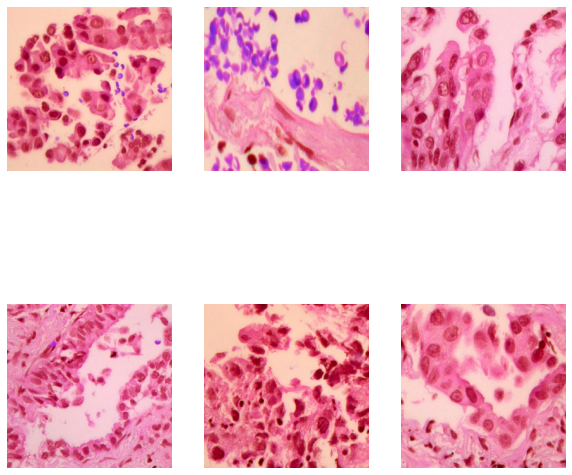

In [ ]:
display_samples(load_dataset(LC_train_FILENAMES).batch(1), 2, 3)

# Building Model

## Generator model

In [ ]:
OUTPUT_CHANNELS = 3

def generator_fn():
    inputs = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4),                          # (bs, 64, 64, 128)
        downsample(256, 4),                          # (bs, 32, 32, 256)
        downsample(512, 4),                          # (bs, 16, 16, 512)
        downsample(512, 4),                          # (bs, 8, 8, 512)
        downsample(512, 4),                          # (bs, 4, 4, 512)
        downsample(512, 4),                          # (bs, 2, 2, 512)
        downsample(512, 4),                          # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4),                     # (bs, 16, 16, 1024)
        upsample(256, 4),                     # (bs, 32, 32, 512)
        upsample(128, 4),                     # (bs, 64, 64, 256)
        upsample(64, 4),                      # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Discriminator model

In [ ]:
def discriminator_fn():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                    kernel_initializer=initializer,
                    use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                    kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return keras.Model(inputs=inp, outputs=last)

## Build model (CycleGAN)

In [ ]:
with strategy.scope():
    LC_generator = generator_fn() # transforms TCGA to LC style
    TCGA_generator = generator_fn() # transforms LC style to be more like TCGA

    LC_discriminator = discriminator_fn() # differentiates real LC images and generated LC images
    TCGA_discriminator = discriminator_fn() # differentiates real TCGA and generated TCGA


class CycleGan(keras.Model):
    def __init__(
        self,
        LC_generator,
        TCGA_generator,
        LC_discriminator,
        TCGA_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.L_gen = LC_generator
        self.T_gen = TCGA_generator
        self.L_disc = LC_discriminator
        self.T_disc = TCGA_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        L_gen_optimizer,
        T_gen_optimizer,
        L_disc_optimizer,
        T_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.L_gen_optimizer = L_gen_optimizer
        self.T_gen_optimizer = T_gen_optimizer
        self.L_disc_optimizer = L_disc_optimizer
        self.T_disc_optimizer = T_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_LC, real_TCGA = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # LC to TCGA back to LC
            fake_LC = self.L_gen(real_TCGA, training=True)
            cycled_TCGA = self.T_gen(fake_LC, training=True)

            # monet to TCGA back to LC
            fake_TCGA = self.T_gen(real_LC, training=True)
            cycled_LC = self.L_gen(fake_TCGA, training=True)

            # generating itself
            same_LC = self.L_gen(real_LC, training=True)
            same_TCGA = self.T_gen(real_TCGA, training=True)

            # discriminator used to check, inputing real images
            disc_real_LC = self.L_disc(real_LC, training=True)
            disc_real_TCGA = self.T_disc(real_TCGA, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_LC = self.L_disc(fake_LC, training=True)
            disc_fake_TCGA = self.T_disc(fake_TCGA, training=True)

            # evaluates generator loss
            LC_gen_loss = self.gen_loss_fn(disc_fake_LC)
            TCGA_gen_loss = self.gen_loss_fn(disc_fake_TCGA)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_LC, cycled_TCGA, self.lambda_cycle) + self.cycle_loss_fn(real_TCGA, cycled_TCGA, self.lambda_cycle)

            # evaluates total generator loss
            total_LC_gen_loss = LC_gen_loss + total_cycle_loss + self.identity_loss_fn(real_LC, same_LC, self.lambda_cycle)
            total_TCGA_gen_loss = TCGA_gen_loss + total_cycle_loss + self.identity_loss_fn(real_TCGA, same_TCGA, self.lambda_cycle)

            # evaluates discriminator loss
            LC_disc_loss = self.disc_loss_fn(disc_real_LC, disc_fake_LC)
            TCGA_disc_loss = self.disc_loss_fn(disc_real_TCGA, disc_fake_TCGA)

        # Calculate the gradients for generator and discriminator
        LC_generator_gradients = tape.gradient(total_LC_gen_loss,
                                                  self.L_gen.trainable_variables)
        TCGA_generator_gradients = tape.gradient(total_TCGA_gen_loss,
                                                  self.T_gen.trainable_variables)

        LC_discriminator_gradients = tape.gradient(LC_disc_loss,
                                                      self.L_disc.trainable_variables)
        TCGA_discriminator_gradients = tape.gradient(TCGA_disc_loss,
                                                      self.T_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.L_gen_optimizer.apply_gradients(zip(LC_generator_gradients,
                                                 self.L_gen.trainable_variables))

        self.T_gen_optimizer.apply_gradients(zip(TCGA_generator_gradients,
                                                 self.T_gen.trainable_variables))

        self.L_disc_optimizer.apply_gradients(zip(LC_discriminator_gradients,
                                                  self.L_disc.trainable_variables))

        self.T_disc_optimizer.apply_gradients(zip(TCGA_discriminator_gradients,
                                                  self.T_disc.trainable_variables))
        
        return {
            'LC_gen_loss': total_LC_gen_loss,
            'TCGA_gen_loss': total_TCGA_gen_loss,
            'LC_disc_loss': LC_disc_loss,
            'TCGA_disc_loss': TCGA_disc_loss
        }

## Loss functions

In [ ]:
with strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

# Train

In [ ]:
with strategy.scope():
    # Create generators
    LC_generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
    TCGA_generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

    # Create discriminators
    LC_discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
    TCGA_discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    # Create GAN
    gan_model_e20 = CycleGan(LC_generator, TCGA_generator, 
                         LC_discriminator, TCGA_discriminator)

    gan_model_e20.compile(L_gen_optimizer=LC_generator_optimizer,
                      T_gen_optimizer=TCGA_generator_optimizer,
                      L_disc_optimizer=LC_discriminator_optimizer,
                      T_disc_optimizer=TCGA_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)
    

history = gan_model_e20.fit(get_gan_dataset(LC_train_FILENAMES, TCGA_train_FILENAMES, batch_size=BATCH_SIZE), 
                        steps_per_epoch=(n_LC_train_samples//BATCH_SIZE),
                        epochs=20,
                        verbose=2).history

Epoch 1/20
450/450 - 112s - LC_gen_loss: 5.6240 - TCGA_gen_loss: 5.5417 - LC_disc_loss: 0.6732 - TCGA_disc_loss: 0.7878 - 112s/epoch - 249ms/step
Epoch 2/20
450/450 - 88s - LC_gen_loss: 5.4183 - TCGA_gen_loss: 5.2521 - LC_disc_loss: 0.7251 - TCGA_disc_loss: 0.6281 - 88s/epoch - 196ms/step
Epoch 3/20
450/450 - 89s - LC_gen_loss: 5.7206 - TCGA_gen_loss: 5.4266 - LC_disc_loss: 0.6173 - TCGA_disc_loss: 0.6812 - 89s/epoch - 197ms/step
Epoch 4/20
450/450 - 89s - LC_gen_loss: 4.6965 - TCGA_gen_loss: 5.0929 - LC_disc_loss: 0.8507 - TCGA_disc_loss: 0.6474 - 89s/epoch - 197ms/step
Epoch 5/20
450/450 - 88s - LC_gen_loss: 6.1373 - TCGA_gen_loss: 5.6358 - LC_disc_loss: 0.6476 - TCGA_disc_loss: 0.6833 - 88s/epoch - 197ms/step
Epoch 6/20
450/450 - 88s - LC_gen_loss: 5.9273 - TCGA_gen_loss: 6.0631 - LC_disc_loss: 0.6975 - TCGA_disc_loss: 0.5559 - 88s/epoch - 197ms/step
Epoch 7/20
450/450 - 89s - LC_gen_loss: 7.7195 - TCGA_gen_loss: 7.1285 - LC_disc_loss: 0.3777 - TCGA_disc_loss: 0.4654 - 89s/epoch - 1

## Save and Load Model

In [ ]:
#LC_generator.save("./Model/CycleGAN_Model/LC_generator20.h5")
cyclegan_model_LC_generator = load_model("./Model/CycleGAN_Model/LC_generator20_all.h5")

In [ ]:
LC_generator.save("./Model/CycleGAN_Model/LC_generator15.h5")
cyclegan_model_LC_generator = load_model("./Model/CycleGAN_Model/LC_generator15.h5")

# Visualize predictions

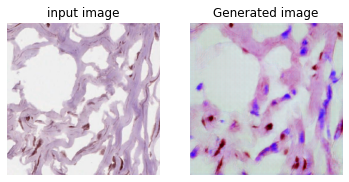

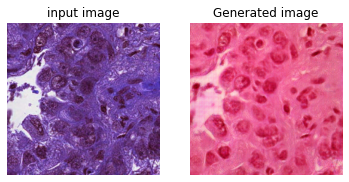

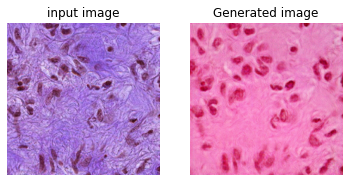

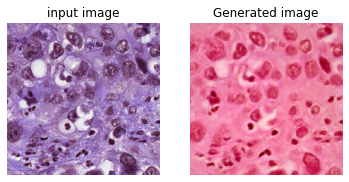

In [ ]:
display_generated_samples(load_dataset(TCGA_train_FILENAMES).batch(1), cyclegan_model_LC_generator, 4) #20

# Transfer and Save Images

In [ ]:
def cyclegan_images_create(path):
    #folder_list=tf.io.gfile.glob(str(path))
    folder_list=glob.glob(str(path))
    #print(folder_list)
    for folder in folder_list:
        folder_path=f'{folder}/*.tfrec'
        newpath=os.path.dirname(folder)
        newpath=os.path.dirname(newpath)
        folder_name=folder.split('/')[-2]
        #file_name=folder.split('/')[-1].split('_')[0]
        file_name=os.path.basename(folder).split('_')[0]
        folder_name=folder_name.split('_')[0]
        newpath=f'{newpath}/{folder_name}_cyclegan/{file_name}/'
        if not os.path.exists(newpath):
            os.mkdir(newpath)
        #print(newpath)
        #folder_FILENAMES=tf.io.gfile.glob(str(folder_path))
        folder_FILENAMES=glob.glob(str(folder_path))
        predict_and_save(load_dataset(folder_FILENAMES).batch(1), cyclegan_model_LC_generator, newpath)


In [ ]:
cyclegan_images_create(path='./Images/TCGA_patch/tfrecord/scc_tfrecord/*')

# Submission file

In [ ]:
shutil.make_archive('./Images/CycleGAN/ZIP', 'zip', './Images/CycleGAN/')

print(f"Generated samples: {len([name for name in os.listdir('./Images/CycleGAN/') if os.path.isfile(os.path.join('./Images/CycleGAN/', name))])}")